# Introduction

## About Dataset

Data set of **400 bird species**. **58388 training images**, **2000 test images** (5 images per species) and **2000 validation images** (5 images per species). This is a very high quality dataset where there is only one bird in each image and the bird typically takes up at least 50% of the pixels in the image. As a result even a moderatly complex model will achieve training and test accuracies in the mid 90% range.

All images are **224 X 224 X 3 color images** in jpg format. Data set includes a train set, test set and validation set. Each set contains 400 sub directories, one for each bird species. The data structure is convenient if you **use the Keras' ImageDataGenerator.flow_from_directory to create the train, test and valid data generators.** The dataset also includes csv files providing information about the birds.

Images were gather from internet searches by species name. Then the images were cropped so that **the bird occupies at least 50% of the pixel in the image.** Then the images were resized to 224 X 224 X3 in jpg format. The cropping ensures that when processed by a CNN there is adequate information in the images to create a highly accurate classifier. Even a moderately robust model should achieve training, validation and test accuracies in the high 90% range. 

All files were also numbered sequential starting from one for each species. So test images are named 1.jpg to 5.jpg. Similarly for validation images. **Training images are** also numbered sequentially **with "zeros" padding.** For example 001.jpg, 002.jpg ... 010.jpg, 011.jpg ... 099.jpg, 100jpg, 102.jpg etc. The zero's padding preserves the file order when used with python file functions and Keras flow from directory.

The training set is not balanced, having a varying number of files per species. However each species has at least 120 training image files. Besides, one other **significant imbalance** in the dataset **is the ratio of male species images to female species images**. **About 85% of the images are of the male and 15% of the female.** Males typical are far more diversely colored while the females of a species are typically bland. Consequently, **male and female images may look entirely different.** Almost all test and validation images are taken from the male of the species. Consequently, **the classifier may not perform as well on female specie images**.

## Table of contents

   1. Initial setup, reusable methods
   2. Data exploration
   3. Data preprocessing
   4. CNN model building, configuration
   5. Results

# Initial setup, reusable methods

In [182]:
import os
import random

import pandas as pd

import numpy as np

import torch

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout

from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

DIR_TRAIN = "100-bird-species/train/"
DIR_TEST = "100-bird-species/test/"
DIR_VALID = "100-bird-species/valid/"


In [199]:
def show_species(classes, species, predicted_species = None):
    fig = plt.figure(figsize=(20,40))
    y = 5
    
    if classes % 5 == 0:
        rows = int(classes / 5)
    else:
        rows = int(classes / 5) + 1
        y = classes

    for row in range(rows):
        for column in range(5):

            # Manipulating the image placings.
            i = row * 5 + column
            if i > classes - 1:
                break    

            specie = species[i]
            
            specie_path = DIR_VALID + specie

            # Naming convention for the images, grabbing the first image for the specific specie.
            f_path = specie_path + "/1.jpg"

            img = mpimg.imread(f_path)
            a = fig.add_subplot(rows, y, i+1)
            imgplot = plt.imshow(img)
            a.axis("off")
            
            if predicted_species != None:
                if specie == predicted_species[i]:
                    a.set_title(specie + "\n" + predicted_species[i], color = "green")
                else:
                    a.set_title(specie + "\n" + predicted_species[i], color = "red")
            else:
                a.set_title(specie)

In [107]:
def classify_image(paths):
    classes = []
    
    for path in paths:
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)

        prediction = model.predict(img_preprocessed, batch_size=10)

        classes.append(np.argmax(prediction, axis = 1)[0])
        
    return(classes)

# Data Exploration

As I already mentioned it in the introduction, we are going to deal with images of different bird species (to be exact, with 400 different one). So in this section, I will present some of the birds. It's also worth to note that I will use images from the validation directory.

Furthermore, we were also provided a CSV files, which can be read using pandas, so let's do that also. They might not be used in later steps though.

In [3]:
birds_csv = pd.read_csv("100-bird-species/birds.csv")
birds_csv

class index                            filepaths  \
0                0        train/ABBOTTS BABBLER/001.jpg   
1                0        train/ABBOTTS BABBLER/002.jpg   
2                0        train/ABBOTTS BABBLER/003.jpg   
3                0        train/ABBOTTS BABBLER/004.jpg   
4                0        train/ABBOTTS BABBLER/005.jpg   
...            ...                                  ...   
62383          399  valid/YELLOW HEADED BLACKBIRD/1.jpg   
62384          399  valid/YELLOW HEADED BLACKBIRD/2.jpg   
62385          399  valid/YELLOW HEADED BLACKBIRD/3.jpg   
62386          399  valid/YELLOW HEADED BLACKBIRD/4.jpg   
62387          399  valid/YELLOW HEADED BLACKBIRD/5.jpg   

                        labels data set  
0              ABBOTTS BABBLER    train  
1              ABBOTTS BABBLER    train  
2              ABBOTTS BABBLER    train  
3              ABBOTTS BABBLER    train  
4              ABBOTTS BABBLER    train  
...                        ...      ...  
62383  YELLOW HEADED BLACKBIRD    valid  
62384  YELLOW HEADED BLACKBIRD    valid  
62385  YELLOW HEADED BLACKBIRD    valid  
62386  YELLOW HEADED BLACKBIRD    valid  
62387  YELLOW HEADED BLACKBIRD    valid  

[62388 rows x 4 columns]

As we can see, this csv file contains class indeces, file paths, labels (name of the specie of the bird) and in which dataset the file belongs to.

In [4]:
birds_latin_csv = pd.read_csv("100-bird-species/birds latin names.csv")
birds_latin_csv

class_index                        class        SCIENTIFIC NAME
0              0              ABBOTTS BABBLER   Malacocincla abbotti
1              1                ABBOTTS BOOBY       Papasula abbotti
2              2   ABYSSINIAN GROUND HORNBILL   Bucorvus abyssinicus
3              3        AFRICAN CROWNED CRANE    Balearica regulorum
4              4       AFRICAN EMERALD CUCKOO   Chrysococcyx cupreus
..           ...                          ...                    ...
395          395     WILSONS BIRD OF PARADISE  Cicinnurus respublica
396          396                    WOOD DUCK             Aix sponsa
397          397  YELLOW BELLIED FLOWERPECKER  Dicaeum melanoxanthum
398          398               YELLOW CACIQUE           Cacicus cela
399          399      YELLOW HEADED BLACKBIRD         Xanthocephalus

[400 rows x 3 columns]

As the file name already implies, this file contains the latin names of the bird species.

For the next step, let's display the first 100 bird species.

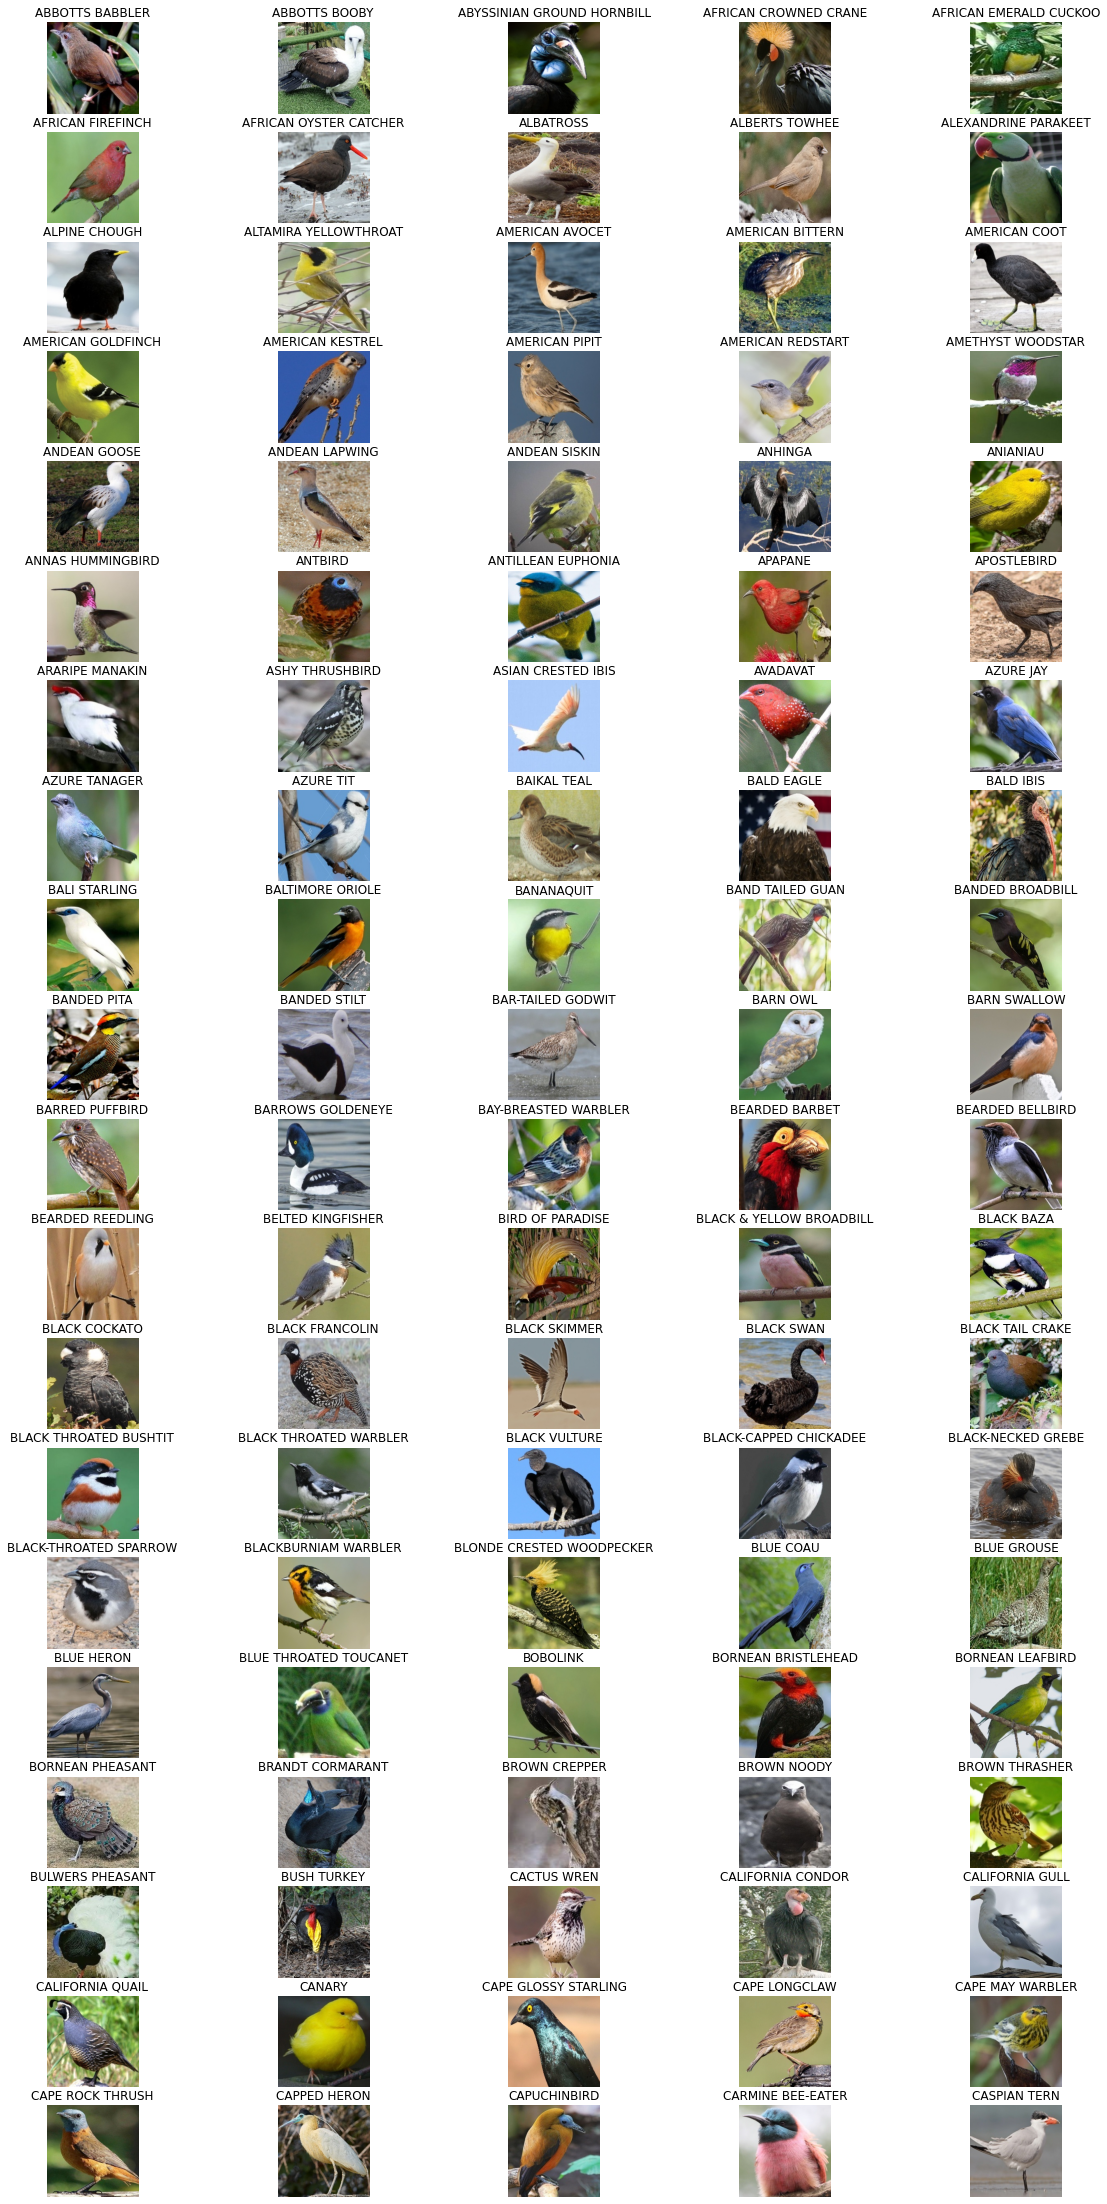

In [201]:
species = birds_latin_csv['class'][:100]
classes = len(species)

show_species(classes, species)

And since I like owls.

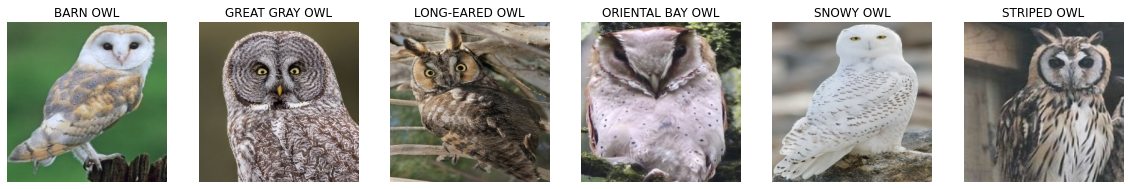

In [202]:
owls = birds_latin_csv[birds_latin_csv['class'].str.contains(" OWL")]['class'].tolist()
classes = len(owls)

show_species(classes, owls)

# Data preprocessing

As it is stated in the introduction, using **Keras' ImageDataGenerator.flow_from_directory** will allow us to work efficiently as the data structure, the way the dataset is set up, allows us to do so.

But what is the use of Keras' ImageDataGenerator?

Shortly, the objective of ImageDataGenerator is to import data with labels easily into the model. But what about data preprocessing?

When working with deep learning models, we often run into particular cases when there is not enough data to train our model with. However, there exists solution for this problem, which is data **augmentation.**

*Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model. It is closely related to oversampling in data analysis.*

<img src="images/data_augmentation.png" />

**Keras' ImageDataGenerator** lets us augment the images in real-time while the model is still training. We can apply any random transformations on each training emage as it is passed to the model. This will not only make our model robust but will also save up on memory. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, etc. ImageDataGenerator class ensures that the model receives new variations of the images at each epoch. But it only returns the transformed images and does not add it to the original corpus of images so  it doesn’t affect the data stored on the disk.

<img src="images/parrot1.jpg" width="375" height="250" /><img src="images/parrot2.png" />

Thus, **ImageDataGenerator.flow_from_directory** will generate batches of tensor image data with real-time data augmentation, to put it shortly.

Argument description used for ImageDataGenerator class and ImageDataGenerator.flow_from_directory function:

**preprocessing_function:**

    - function that will be applied on each input. The function will run after the image is resized and augmented.The function should take one argument: one image (Numpy tensor with rank 3), and should output a Numpy tensor with the same shape.
    
**shear_range:**

    - Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    
**zoom_range:**

    - Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
    
**horizontal_flip:**

    - Boolean. Randomly flip inputs horizontally.
    
**target_size:**

    - tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized.
    
**batch_size:**

    - size of the batches of data (default: 32).
    
**class_mode:**

    - One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned:
    - "categorical" will be 2D one-hot encoded labels,
    - "binary" will be 1D binary labels, "sparse" will be 1D integer labels,
    - "input" will be images identical to input images (mainly used to work with autoencoders).
    - If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict_generator()). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly.
    
It's also important to mention that for the preprocessing_function argument, I set **keras.applications.vgg16.preprocess_input** which preprocesses a tensor or Numpy array encoding a batch of images. The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

In [7]:
train_datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input, # Preprocesses training dataset
        shear_range = 0.1,
        zoom_range = 0.1,
        horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(
        DIR_TRAIN,
        target_size = (224, 224),
        batch_size = 64,
        class_mode = 'categorical') # Categories -> species

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        DIR_TEST,
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'categorical')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(
        DIR_VALID,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


# CNN model building, configuration

## Transfer learning

For my CNN model, I will utilize transfer learning and choose a pretrained model. But what is transfer learning?

**Transfer learning (TL)** is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.

So the idea is that it has learned to recognize many features on all of this data, and that you will benefit from this knowledge.

## VGG16 – Convolutional Network for Classification and Detection

For my pretrained CNN model, I will use **VGG16**. VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014 (Large Scale Visual Recognition Challenge 2014). It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

<img src="images/vgg16_1.png" />

### The Architecture

The architecture depicted below is VGG16.
<img src="images/vgg16.png" />

The input to cov1 layer is of fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional (conv.) layers, where the filters were used with a very small receptive field: 3×3 (which is the smallest size to capture the notion of left/right, up/down, center). In one of the configurations, it also utilizes 1×1 convolution filters, which can be seen as a linear transformation of the input channels (followed by non-linearity). The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. Spatial pooling is carried out by five max-pooling layers, which follow some of the conv.  layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window, with stride 2.

Three Fully-Connected (FC) layers follow a stack of convolutional layers (which has a different depth in different architectures): the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer. The configuration of the fully connected layers is the same in all networks.

All hidden layers are equipped with the rectification (ReLU) non-linearity. It is also noted that none of the networks (except for one) contain Local Response Normalisation (LRN), such normalization does not improve the performance on the ILSVRC dataset, but leads to increased memory consumption and computation time.

## Implementation

### Base model configuration

I use Keras' **application.VGG16** function to implement the VGG16 CNN model.

Argument description used for application.VGG16 function:

**include_top:**

    - whether to include the 3 fully-connected layers at the top of the network.
    
**weights:**

    - one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

**input_shape:**

    - optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with channels_last data format) or (3, 224, 224) (with channels_first data format). It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

By setting the *include_top* to *false*, we will esentially cut the 3 fully connected layers at the top of the network (or at the end of it, matter of perspective). This is done to customize the pretrained model to fit our needs. In this case, since we have 400 classes to work with, I will use a softmax with 400 hidden units to classify the input. The softmax layer will output the value between 0 and 1 based on the confidence of the model that which class the images belongs to. I also set the kernel initializer to *glorot_normal* which is a common initialization scheme for deep NNs. It initializes each weight with a small Gaussian value with mean = 0.0 and variance based on the fan-in and fan-out of the weight.

<img src="images/vgg16_modified.png" />

For the *weights* argument, I will use the *imagenet* option. **ImageNet** is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories.

Lastly, *input_shape* is given, since we are working with RGB images with a size of 224x224.

In [8]:
# Instantiate a base model with pre-trained weigts.
base_model = keras.applications.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (224,224,3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
#freeze the base model
base_model.trainable = False

In [10]:
#Create new model on top
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(400, activation = 'softmax', kernel_initializer = 'glorot_normal'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 400)               10035600  
                                                                 
Total params: 24,750,288
Trainable params: 10,035,600
Non-trainable params: 14,714,688
_________________________________________________________________




### Model tranining

For this part, there will be two important functions, namly **complie** and **fit**. *Complie* will configure the model for training and *fit* trains the model for a fixed number of epochs (iterations on a dataset).

Argument description used for complie function:

**optimizer:**

    - String (name of optimizer) or optimizer instance.
    
**loss:**

    - Loss function. May be a string (name of loss function), or a tf.keras.losses.Loss instance. A loss function is any callable with the signature loss = fn(y_true, y_pred), where y_true are the ground truth values, and y_pred are the model's predictions.
    
**metrics:**

    - List of metrics to be evaluated by the model during training and testing. Typically you will use metrics=['accuracy'].

For the *optimizer* I will use Adam's optimizer to reach to the global minima while training our model. If we are stuck in local minima while training then the Adam optimiser will help us to get out of local minima and reach global minima. We will also specify the learning rate of the optimiser, here in this case it is set at 0.0001. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.
 
For the *loss* parameter, I will use *categorical crossentropy* which is a loss function for multi-class classification model where there are two or more output labels. So it's perfectly suits our model.

For *metrics* I will use *accuracy* which calculates how often predictions equal labels, so that we can determine the accuracy of our model later on.

Argument description used for fit function:

**x:**

    - Input data. It could be:
        - A Numpy array (or array-like), or a list of arrays (in case the model has multiple inputs).
        - A TensorFlow tensor, or a list of tensors (in case the model has multiple inputs).
        - A dict mapping input names to the corresponding array/tensors, if the model has named inputs.
        - A tf.data dataset. Should return a tuple of either (inputs, targets) or (inputs, targets, sample_weights).
        - A generator or keras.utils.Sequence returning (inputs, targets) or (inputs, targets, sample_weights).
        - A tf.keras.utils.experimental.DatasetCreator, which wraps a callable that takes a single argument of type tf.distribute.InputContext, and returns a tf.data.Dataset. DatasetCreator should be used when users prefer to specify the per-replica batching and sharding logic for the Dataset. See tf.keras.utils.experimental.DatasetCreator doc for more information. A more detailed description of unpacking behavior for iterator types (Dataset, generator, Sequence) is given below. If using tf.distribute.experimental.ParameterServerStrategy, only DatasetCreator type is supported for x.
    
**epochs:**

    - Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None).
    
**validation_data:**

    - Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. Thus, note the fact that the validation loss of data provided using validation_split or validation_data is not affected by regularization layers like noise and dropout. 
    
**workers:**

    - Integer. Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.

For the *x* input, I will sepcify our training generator, since it is our input, the images with data augmentation.

I will set 4 *epochs*. For this parameter, the more the better. Naturally, until we improve our model, but there are tools avoid training the model needlessly, like EarlyStopping which stops the training when a monitored metric has stopped improving.

For *validation_data* I will use our validation generator which are the pictures provided for our model's validation.

By setting *workers* to other than the default 1, Keras will spawn threads when ingesting data batches, thus improving performance.

In [12]:
torch.cuda.is_available()

True

In [13]:
print(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

cuda:0


In [14]:
#Train the model on new data.
model.compile(
    optimizer = optimizers.Adam(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 4,
    validation_data = val_generator,
    workers = 10)

Epoch 1/4
913/913 [==============================] - 733s 786ms/step - loss: 11.7572 - accuracy: 0.4946 - val_loss: 3.9312 - val_accuracy: 0.7970
Epoch 2/4
913/913 [==============================] - 655s 717ms/step - loss: 2.7068 - accuracy: 0.8268 - val_loss: 3.1591 - val_accuracy: 0.8440
Epoch 3/4
913/913 [==============================] - 656s 717ms/step - loss: 1.5769 - accuracy: 0.8906 - val_loss: 3.3012 - val_accuracy: 0.8570
Epoch 4/4
913/913 [==============================] - 656s 718ms/step - loss: 1.1877 - accuracy: 0.9196 - val_loss: 3.1966 - val_accuracy: 0.8800


# Results

## Loss function, accuracy

As to be expected, the loss decreases as the model processes the epochs, and thge accuracy increases. The model reached ~90% accuracy on model evaluation using the provided test samples.


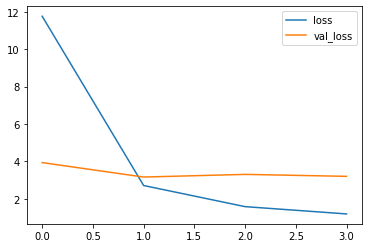

In [16]:
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

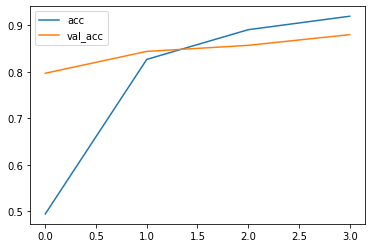

In [17]:
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [18]:
model.evaluate(test_generator,workers=10)

63/63 [==============================] - 22s 343ms/step - loss: 2.0499 - accuracy: 0.8940


[2.049943447113037, 0.8939999938011169]

## Visualizations

For vizalisation, I use two approaches. First, I use the dataset itself as the source, pick random pictures of species, classify them using the model then compare the result with the model's result.

Secondly, I randomly pick pictures of birds on the internet and then let the model classify them.

Images are first converted to numpy array using *img_to_array* then preprocessed using *VGG16.preprocess_input*. Then I use Keras' *predict* function on the trained model.

However, since I used **softmax activation function**, it doesn't compute the prediction, but rather a discrete probability distribution over the target classes. To put it simply, this means that Softmax computes the probability that the input belongs to a particular class, for each class. The values in each row summate to 1 - or 100%, which is a characteristic of a valid probability distribution.

To convert the prediction to an actual class, we have to use **argmax** (or "maximum argument", index of the maximum value) for each element which will only choose the best or the most probable class for the output value.

1/1 [==============================] - 0s 13ms/step


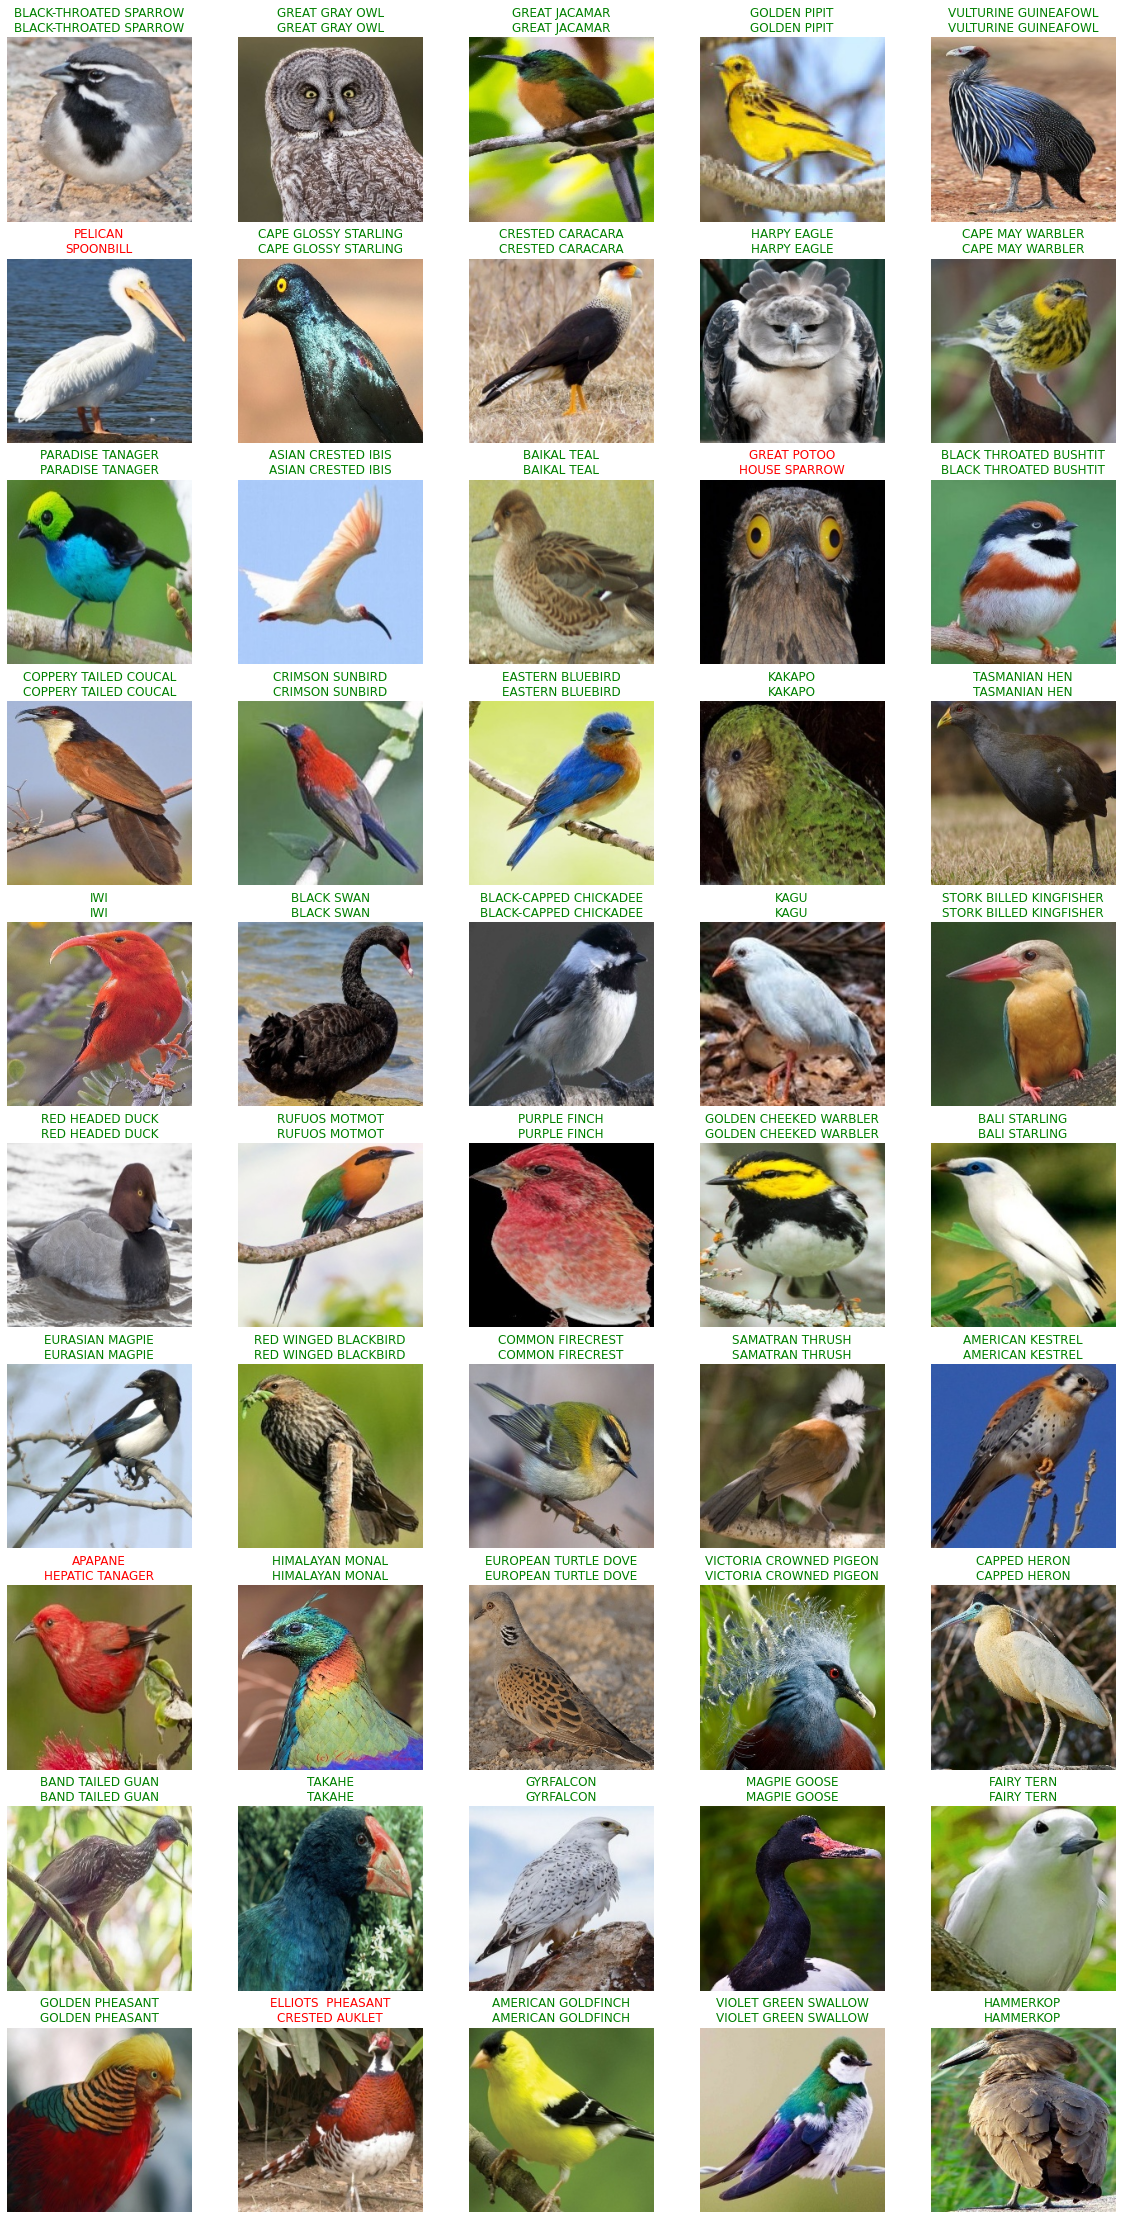

In [214]:
num_prediction = 50
random_numbers = random.sample(range(0, 399), num_prediction)
specie_names = []
paths = []

for number in random_numbers:
    specie_names.append(birds_latin_csv["class"][number])
    path = DIR_TEST + specie_names[-1] + "/" + str(random.randint(1,5)) + ".jpg"
    paths.append(path)
    
indeces = classify_image(paths)
predicted_specie_names = []

for index in indeces:
    predicted_specie_names.append(birds_latin_csv["class"][index])

show_species(num_prediction, specie_names, predicted_specie_names)

1/1 [==============================] - 0s 16ms/step


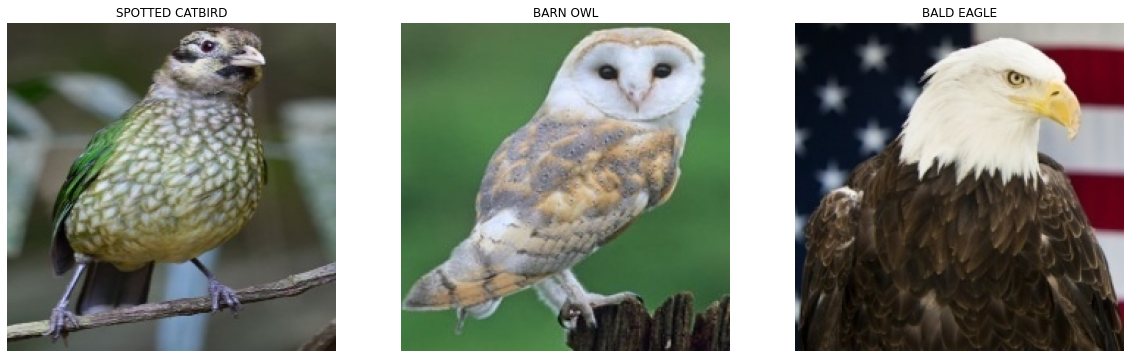

In [215]:
paths = ["images/owl1.jpg", "images/owl2.jpg", "images/eagle.jpg"]
classes = len(paths)
indeces = classify_image(paths)
predicted_specie_names = []

for index in indeces:
    predicted_specie_names.append(birds_latin_csv["class"][index])

show_species(classes, predicted_specie_names)

# References

<img src="images/giants.jpg" />

Bird classification Using CNN - https://www.kaggle.com/code/rocklen/bird-classification-using-cnn

Explore Bird Dataset - https://www.kaggle.com/code/gpiosenka/explore-bird-dataset

[Bird-species] Standing on the shoulders of Giant! - https://www.kaggle.com/code/ohseokkim/bird-species-standing-on-the-shoulders-of-giant#Introduction

PyTorch Starter - Image Classification - https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

100+ birds CNN - https://www.kaggle.com/code/akimball002/100-birds-cnn

Bird_CNN_VGG16 99% Accuracy on test set - https://www.kaggle.com/code/aditya276/bird-cnn-vgg16-99-accuracy-on-test-set/notebook

CNN Birds tf Transfer Learning - https://www.kaggle.com/code/alincijov/cnn-birds-tf-transfer-learning/notebook

Image Augmentation on the fly using Keras ImageDataGenerator! - https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Keras, VGG16 and VGG19 - https://keras.io/api/applications/vgg/#vgg16-function

Keras, Model training APIs - https://keras.io/api/models/model_training_apis/

Tensorflow, tf.keras.preprocessing.image.ImageDataGenerator - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Tensorflow, tf.keras.applications.vgg16.preprocess_input - https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input

Tensorflow, tf.keras.Model - https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

6x Faster Data Processing With Keras fit_generator Workers - https://medium.com/missinglink-deep-learning-platform/6x-faster-data-processing-with-keras-fit-generator-workers-e8d2e7cb62fd

Step by step VGG16 implementation in Keras for beginners - https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

How to predict an image using CNN with Keras? - https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817

VGG16 – Convolutional Network for Classification and Detection - https://neurohive.io/en/popular-networks/vgg16/

Transfer learning - https://en.wikipedia.org/wiki/Transfer_learning

Data augmentation - https://en.wikipedia.org/wiki/Data_augmentation

Using keras fit/fit_generator with max_queue_size, workers and use_multiprocessing - https://stackoverflow.com/questions/58835313/using-keras-fit-fit-generator-with-max-queue-size-workers-and-use-multiprocessi

How to predict input image using trained model in Keras? - https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

how-to-predict-new-samples-with-your-keras-model - https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-keras-model.md

